step 100 of 1000
step 200 of 1000
step 300 of 1000
step 400 of 1000
step 500 of 1000
step 600 of 1000
step 700 of 1000
step 800 of 1000
step 900 of 1000
step 1000 of 1000


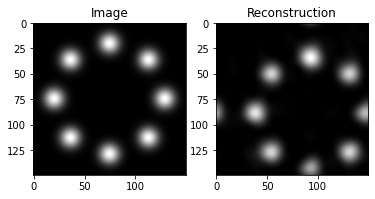

In [21]:
%run example.py

step 100 of 1000
step 200 of 1000
step 300 of 1000
step 400 of 1000
step 500 of 1000
step 600 of 1000
step 700 of 1000
step 800 of 1000
step 900 of 1000
step 1000 of 1000


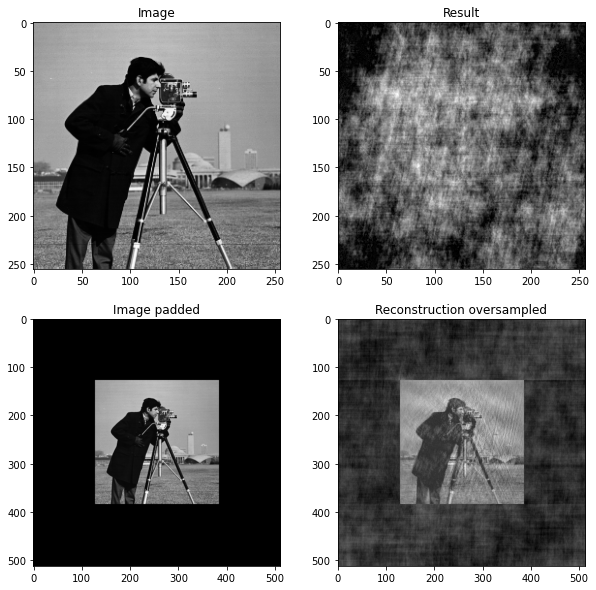

In [25]:
%run example_oversampling.py

In [3]:
import numpy as np

def fienup_phase_retrieval(mag, mask=None, beta=0.8, 
                           steps=200, mode='hybrid', verbose=True):
    """
    Implementation of Fienup's phase-retrieval methods. This function
    implements the input-output, the output-output and the hybrid method.
    
    Note: Mode 'output-output' and beta=1 results in 
    the Gerchberg-Saxton algorithm. Mode 'input-output' does not work properly -- need fix!
    
    Parameters:
        mag: Measured magnitudes of Fourier transform
        mask: Binary array indicating where the image should be
              if padding is known
        beta: Positive step size
        steps: Number of iterations
        mode: Which algorithm to use
              (can be 'input-output', 'output-output' or 'hybrid')
        verbose: If True, progress is shown
    
    Returns:
        x: Reconstructed image
    """
    
    assert beta > 0, 'step size must be a positive number'
    assert steps > 0, 'steps must be a positive number'
    assert mode == 'input-output' or mode == 'output-output'\
        or mode == 'hybrid',\
    'mode must be \'input-output\', \'output-output\' or \'hybrid\''
    
    if mask is None:
        mask = np.ones(mag.shape)
        
    assert mag.shape == mask.shape, 'mask and mag must have same shape'
    
    # sample random phase and initialize image x 
    y_hat = mag*np.exp(1j*2*np.pi*np.random.rand(*mag.shape))
    x = np.zeros(mag.shape)
    
    # previous iterate
    x_p = None
        
    # main loop
    for i in range(1, steps+1):
        # show progress
        if i % 100 == 0 and verbose: 
            print("step", i, "of", steps)
        
        # inverse fourier transform
        y = np.real(np.fft.ifft2(y_hat))
        
        # previous iterate
        if x_p is None:
            x_p = y
        else:
            x_p = x 
        
        # updates for elements that satisfy object domain constraints
        if mode == "output-output" or mode == "hybrid":
            x = y
            
        # find elements that violate object domain constraints 
        # or are not masked
        indices = np.logical_or(np.logical_and(y<0, mask), 
                                np.logical_not(mask))
        
        # updates for elements that violate object domain constraints
        if mode == "hybrid" or mode == "input-output":
            x[indices] = x_p[indices]-beta*y[indices] 
        elif mode == "output-output":
            x[indices] = y[indices]-beta*y[indices] 
        
        # fourier transform
        x_hat = np.fft.fft2(x)
        
        # satisfy fourier domain constraints
        # (replace magnitude with input magnitude)
        y_hat = mag*np.exp(1j*np.angle(x_hat))
    return x


In [187]:
import numpy as np

def fienup_phase_retrieval_complex(nonpadded_image, mag, osr=3, mask=None, beta=0.8, 
                           steps=200, mode='hybrid', verbose=True):
    """
    Implementation of Fienup's phase-retrieval methods. This function
    implements the input-output, the output-output and the hybrid method.
    
    Note: Mode 'output-output' and beta=1 results in 
    the Gerchberg-Saxton algorithm. Mode 'input-output' does not work properly -- need fix!
    
    Parameters:
        nonpadded_image: original image/model without padding.
        osr: real space oversample ratio. Default=3.
        mag: Measured magnitudes of Fourier transform
        mask: Binary array indicating where the image should be
              if padding is known
        beta: Positive step size
        steps: Number of iterations
        mode: Which algorithm to use
              (can be 'input-output', 'output-output' or 'hybrid')
        verbose: If True, progress is shown
    
    Returns:
        x: Reconstructed image
        F_error: K-space magnitude error.
    """
    

    
    assert beta > 0, 'step size must be a positive number'
    assert steps > 0, 'steps must be a positive number'
    assert mode == 'input-output' or mode == 'output-output'\
        or mode == 'hybrid',\
    'mode must be \'input-output\', \'output-output\' or \'hybrid\''
    
    if mask is None:
        mask = np.ones(mag.shape)
        
    assert mag.shape == mask.shape, 'mask and mag must have same shape'
    
    # sample random phase and initialize image x 
    np.random.seed(12)
    y_hat = mag*np.exp(1j*2*np.pi*np.random.rand(*mag.shape))
    x = np.zeros(mag.shape)
    
    # previous iterate
    x_p = None
        
    mag_ideal = np.absolute(np.fft.fft2(nonpadded_image))
    ndim = nonpadded_image.shape[0]
    F_error = np.zeros(steps+1)
    
    # main loop
    for i in range(1, steps+1):
        # show progress
        if i % 100 == 0 and verbose: 
            print("step", i, "of", steps)
        
        # inverse fourier transform
        #y = np.real(np.fft.ifft2(y_hat))
        #y2 = np.fft.ifft2(y_hat)
        y = np.fft.ifft2(y_hat)
        
        # previous iterate
        if x_p is None:
            x_p = y
        else:
            x_p = x 
        
        # updates for elements that satisfy object domain constraints
        if mode == "output-output" or mode == "hybrid":
            x = y
        else:    #'input-output' algorithm.
            x = x_p
                    
            
        # find elements that violate object domain constraints 
        # or are not masked (with imaginary non-negativity constraint)
        indices = np.logical_or(np.logical_and(np.imag(y)<0, mask), 
                                np.logical_not(mask))
        ####indices = np.logical_not(mask)  #Remove the nonnegativity constraint for complex value PR!!
        
        # updates for elements that violate object domain constraints
        if mode == "hybrid" or mode == "input-output":
            x[indices] = x_p[indices]-beta*y[indices] 
        elif mode == "output-output":
            x[indices] = y[indices]-beta*y[indices] #if beta==1, it equals to ER algorithm.
        
        # fourier transform
        x_hat = np.fft.fft2(x)
        
        # satisfy fourier domain constraints
        # (replace magnitude with input magnitude)
        y_hat = mag*np.exp(1j*np.angle(x_hat))
        
        
        mag_real = np.absolute(np.fft.fft2(x[int((osr-1)*ndim/2):int((osr-1)*ndim/2)+ndim, int((osr-1)*ndim/2):int((osr-1)*ndim/2)+ndim]))
        F_error[i] = np.sum(np.absolute(mag_ideal - mag_real))/np.sum(mag_ideal)
        
    return (x, F_error)



(256, 256)
256
step 100 of 1000
step 200 of 1000
step 300 of 1000
step 400 of 1000
step 500 of 1000
step 600 of 1000
step 700 of 1000
step 800 of 1000
step 900 of 1000
step 1000 of 1000


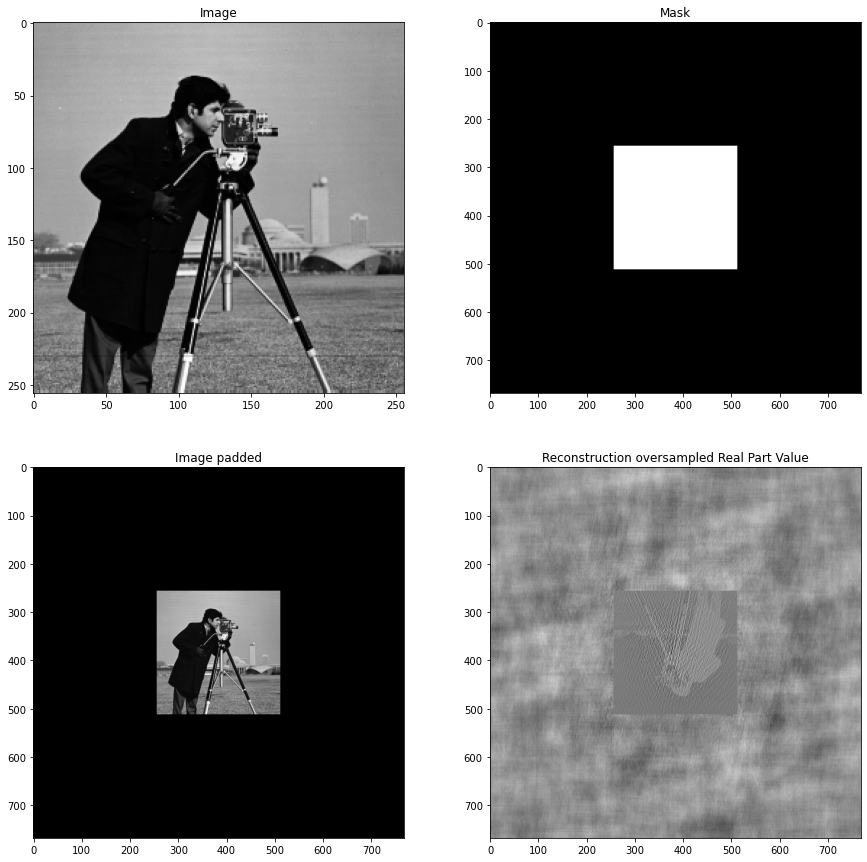

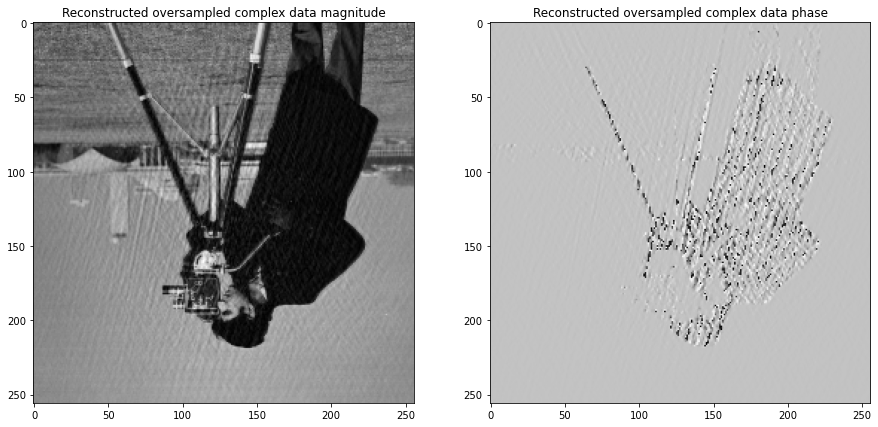

Text(0.5, 0, 'Iterations')

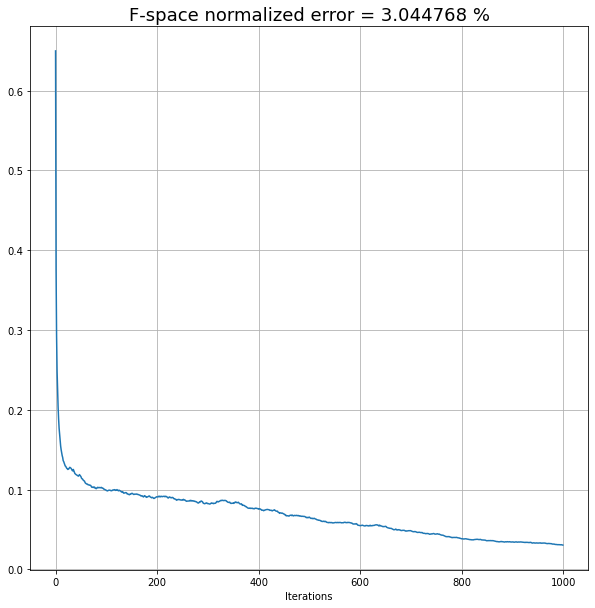

In [203]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
#from phase_retrieval import fienup_phase_retrieval


image = imageio.imread('cameraman.png', as_gray=True)
print(image.shape)
image_dim = image.shape[0]  #Must be even number!
osr = 3
print(int((osr-1)*image_dim/2)) #Zero to be padded on each side, before and after.


#Now oversampling in real space by padding zeros.
image_padded = np.pad(image, int((osr-1)*image_dim/2), 'constant')
magnitudes_oversampled = np.abs(np.fft.fft2(image_padded))
mask = np.pad(np.ones((image_dim,image_dim)), int((osr-1)*image_dim/2), 'constant')
result_oversampled, F_error = fienup_phase_retrieval_complex(image, magnitudes_oversampled, osr=osr, beta=0.9,
                                            steps=1000, mode = 'hybrid',
                                            mask=mask,
                                            verbose=True)


if isinstance(result_oversampled, complex):
    print ('Output is complex')
    
plt.figure(figsize=(15,15))
plt.subplot(221)
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.subplot(222)
plt.imshow(mask, cmap='gray')
plt.title('Mask')
plt.subplot(223)
plt.imshow(image_padded, cmap='gray')
plt.title('Image padded')
plt.subplot(224)
plt.imshow(np.real(result_oversampled), cmap='gray')
plt.title('Reconstruction oversampled Real Part Value')
plt.show()

plt.figure(figsize=(15, 15))
plt.subplot(1,2,1)
plt.imshow(np.absolute(result_oversampled[int((osr-1)*image_dim/2):int((osr-1)*image_dim/2)+image_dim, int((osr-1)*image_dim/2):int((osr-1)*image_dim/2)+image_dim]), cmap='gray')
plt.title('Reconstructed oversampled complex data magnitude')
plt.subplot(1,2,2)
plt.imshow(np.angle(result_oversampled[int((osr-1)*image_dim/2):int((osr-1)*image_dim/2)+image_dim, int((osr-1)*image_dim/2):int((osr-1)*image_dim/2)+image_dim]), cmap='gray')
plt.title('Reconstructed oversampled complex data phase')        
plt.show()

plt.figure(figsize=(10, 10))
plt.plot(F_error[1:len(F_error)])
plt.grid()
final_F_error = F_error[len(F_error)-1]*100
plt.title("F-space normalized error = %f " %final_F_error +  "%", fontsize=18)
plt.xlabel('Iterations')

1.3333333333333334e-06
301
(90601,)
rfieldj shape =  (301, 301)
ifieldj shape =  (301, 301)
true_fieldj shape =  (300, 300)
fieldj shape = (600, 600)
Original E-field dimension =  (600, 600)
After padding E-field dimension =  (1200, 1200)
After padding True E-field dimension =  (600, 600)


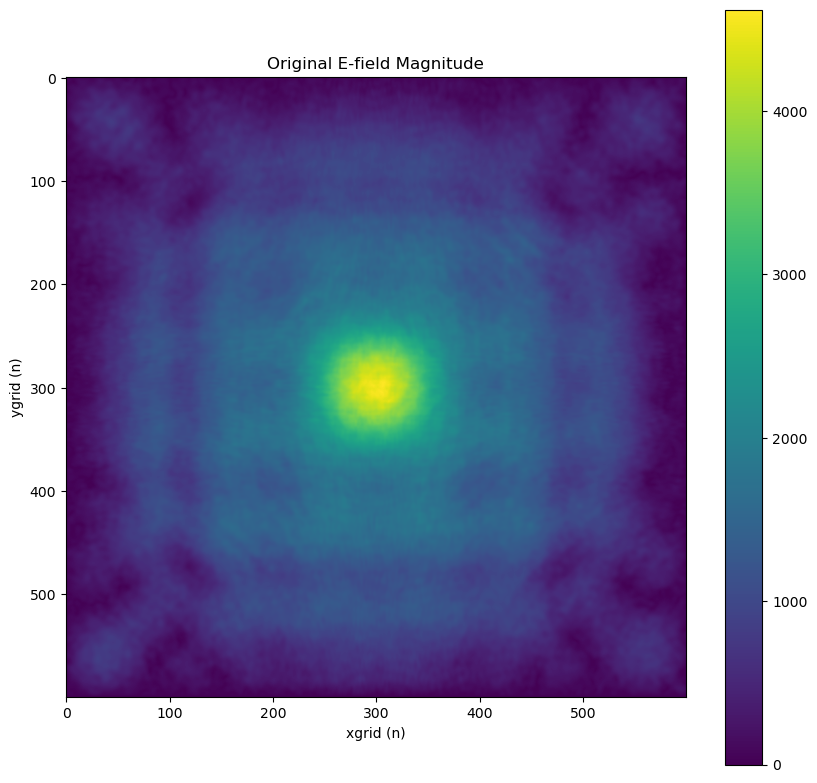

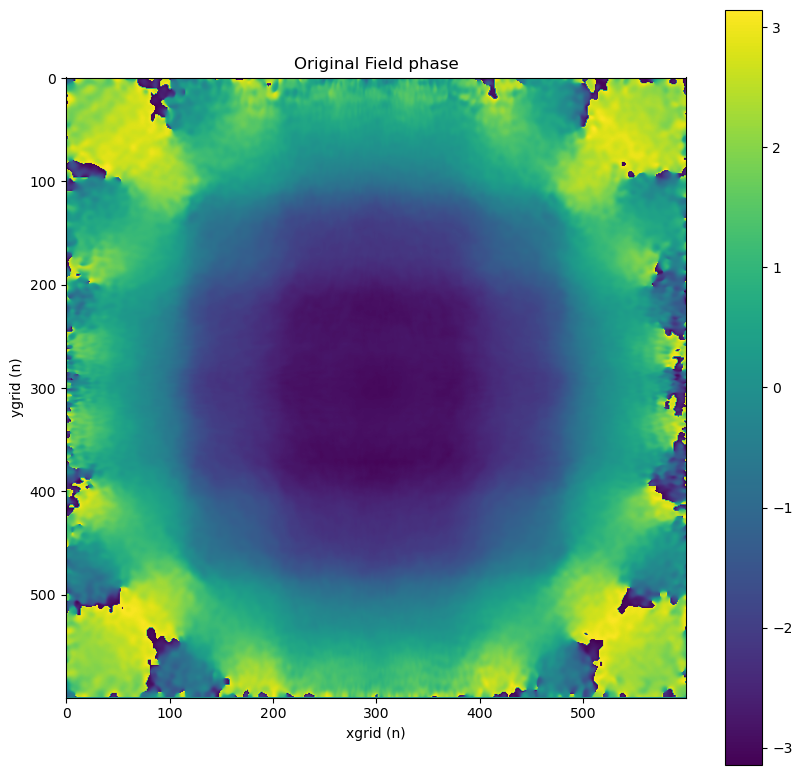

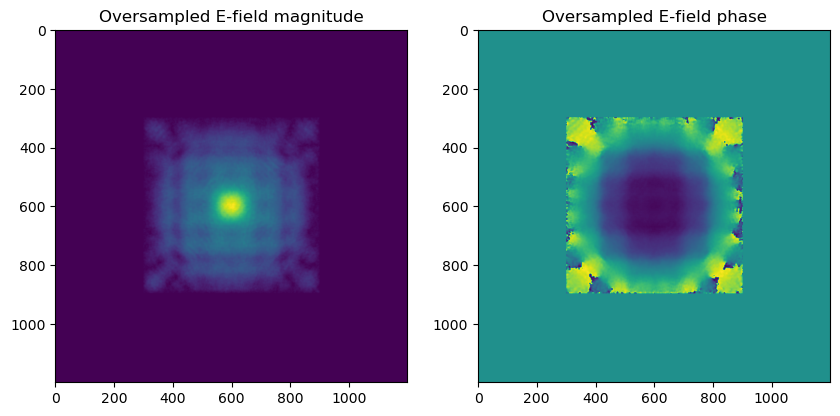

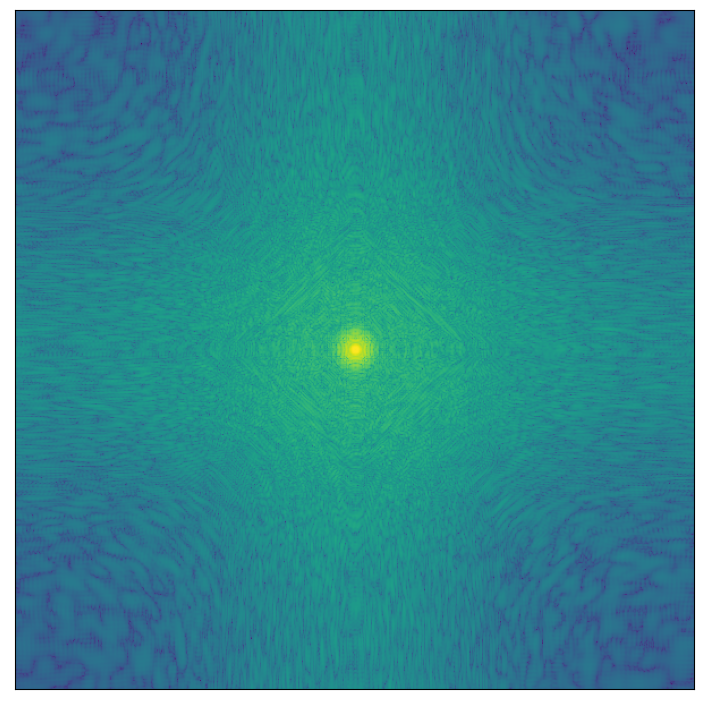

In [191]:
import numpy as np
import imageio
import h5py
import matplotlib.pyplot as plt
from scipy.interpolate import RectBivariateSpline

#Modfied from Juhao's input to plot 2-D field distribution (01/17/2022)
with h5py.File('/Users/kennethshui/python_dir/iCloud_Kenneth/test_pha/many_spikes.643.fld.h5','r') as fldj:
    
    rfieldj = fldj['slice002600/field-real'][()]
    ifieldj = fldj['slice002600/field-imag'][()]
    gridsizej = fldj['gridsize'][()][0]    #1.333e-6, 1.33um
    gridpointsj= fldj['gridpoints'][()][0]     #301

    
# Data pre-processing: Make imaginary non-negative
#rfieldj = np.abs(rfieldj)
#ifieldj = np.abs(ifieldj)
    

print(gridsizej)
print(gridpointsj)
print(rfieldj.shape)

#gridpointsj = 300  #overwirte!

rfieldj = rfieldj.reshape([gridpointsj,gridpointsj])
ifieldj = ifieldj.reshape([gridpointsj,gridpointsj])
###rfieldj = rfieldj[125:175, 125:175]
###ifieldj = ifieldj[125:175, 125:175]
print('rfieldj shape = ', rfieldj.shape)
print('ifieldj shape = ', ifieldj.shape)

true_fieldj = rfieldj[0:300, 0:300]+1j*ifieldj[0:300, 0:300]
###true_fieldj = rfieldj+1j*ifieldj
###gridpointsj = 51
print('true_fieldj shape = ', true_fieldj.shape)

#Professor's coordinate system, -150 to 150
xmaxj = (gridpointsj-1)/2*gridsizej*1e6 # unit: m=>um
xminj = -xmaxj
ymaxj = xmaxj
yminj = -ymaxj

#Still use 0~300 as used in the conf paper to be consistent.
#xmaxj = (gridpointsj-1)/1*gridsizej*1e6 # unit: m=>um
xmaxj = (gridpointsj-1)/1 # unit: ngrid to match the paper
xminj = 0
ymaxj = xmaxj
yminj = 0

frj = RectBivariateSpline(np.linspace(xminj,xmaxj,301),np.linspace(yminj,ymaxj,301),rfieldj)
fij = RectBivariateSpline(np.linspace(xminj,xmaxj,301),np.linspace(yminj,ymaxj,301),ifieldj)
###frj = RectBivariateSpline(np.linspace(xminj,xmaxj,50),np.linspace(yminj,ymaxj,50),rfieldj)
###fij = RectBivariateSpline(np.linspace(xminj,xmaxj,50),np.linspace(yminj,ymaxj,50),ifieldj)


# interpolate to make pixels a factor of 6 smaller. =>Reduce the size to 2x smaller on 07/10/2022
#xij = np.linspace(xminj,xmaxj,1800)
#yij = np.linspace(yminj,ymaxj,1800)
xij = np.linspace(xminj,xmaxj,600)  #2x interpolation for plot purpose.
yij = np.linspace(yminj,ymaxj,600)
###xij = np.linspace(xminj,xmaxj,100)  #2x interpolation for plot purpose.
###yij = np.linspace(yminj,ymaxj,100)

xij,yij = np.meshgrid(xij,yij)

#Added on 07/11 without interpolation.
#xij = 

rfieldj = frj.ev(yij,xij)
ifieldj = fij.ev(yij,xij)
    
fieldj = rfieldj+1j*ifieldj
# field=field.reshape([gridpoints,gridpoints])

# field[np.abs(field)<50] = 0

print('fieldj shape =', fieldj.shape)
###Important: osr is defined here!
osr=2;
image_dim=fieldj.shape
print('Original E-field dimension = ', image_dim)

pad_fieldj = np.pad(fieldj, int((osr-1)*image_dim[0]/2), 'constant')
print('After padding E-field dimension = ', pad_fieldj.shape)

#Use true_fieldj!
image_dim2 = true_fieldj.shape
true_pad_fieldj = np.pad(true_fieldj, int((osr-1)*image_dim2[0]/2), 'constant')
print('After padding True E-field dimension = ', true_pad_fieldj.shape)

plt.figure(figsize=(10, 10), dpi=100)
#plt.imshow(np.abs(fieldj),extent=(xminj,xmaxj,yminj,ymaxj))
plt.imshow(np.abs(fieldj))
plt.xlabel('xgrid (n)')
plt.ylabel('ygrid (n)')
plt.title('Original E-field Magnitude')
plt.colorbar()
#ax = plt.gca()
#ax.axes.xaxis.set_visible(False)
#ax.axes.yaxis.set_visible(False)
#plt.savefig("Efield_Mag.jpg")

plt.figure(figsize=(10, 10), dpi=100)
#plt.imshow(np.angle(fieldj),extent=(xminj,xmaxj,yminj,ymaxj))
plt.imshow(np.angle(fieldj))
#plt.xlabel('x (um)')
#plt.ylabel('y (um)')
plt.xlabel('xgrid (n)')
plt.ylabel('ygrid (n)')
plt.title('Original Field phase')
plt.colorbar()

plt.figure(figsize=(10, 10), dpi=100)
plt.subplot(1,2,1)
plt.imshow(np.abs(pad_fieldj))
plt.title('Oversampled E-field magnitude')
#plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(np.angle(pad_fieldj))
plt.title('Oversampled E-field phase')
#plt.colorbar()

# Show the retrieved field to compare
#F_Space_Mag = np.abs(np.fft.fft2(pad_fieldj))
F_Space_Mag = np.abs(np.fft.fft2(true_pad_fieldj))
plt.figure(figsize=(16, 9), dpi=100)
plt.imshow(np.fft.fftshift(np.log(F_Space_Mag)))
ax = plt.gca()
ax.set_aspect('equal')
ax.margins(0)
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
#plt.savefig("PR_Image_Tuelwer/Efield_Diff_Pat.jpg", dpi = 100, bbox_inches = 'tight')
#plt.savefig("Efield_Diff_Pat_Nologshift.jpg", dpi = 100, bbox_inches = 'tight')

<IPython.core.display.Javascript object>


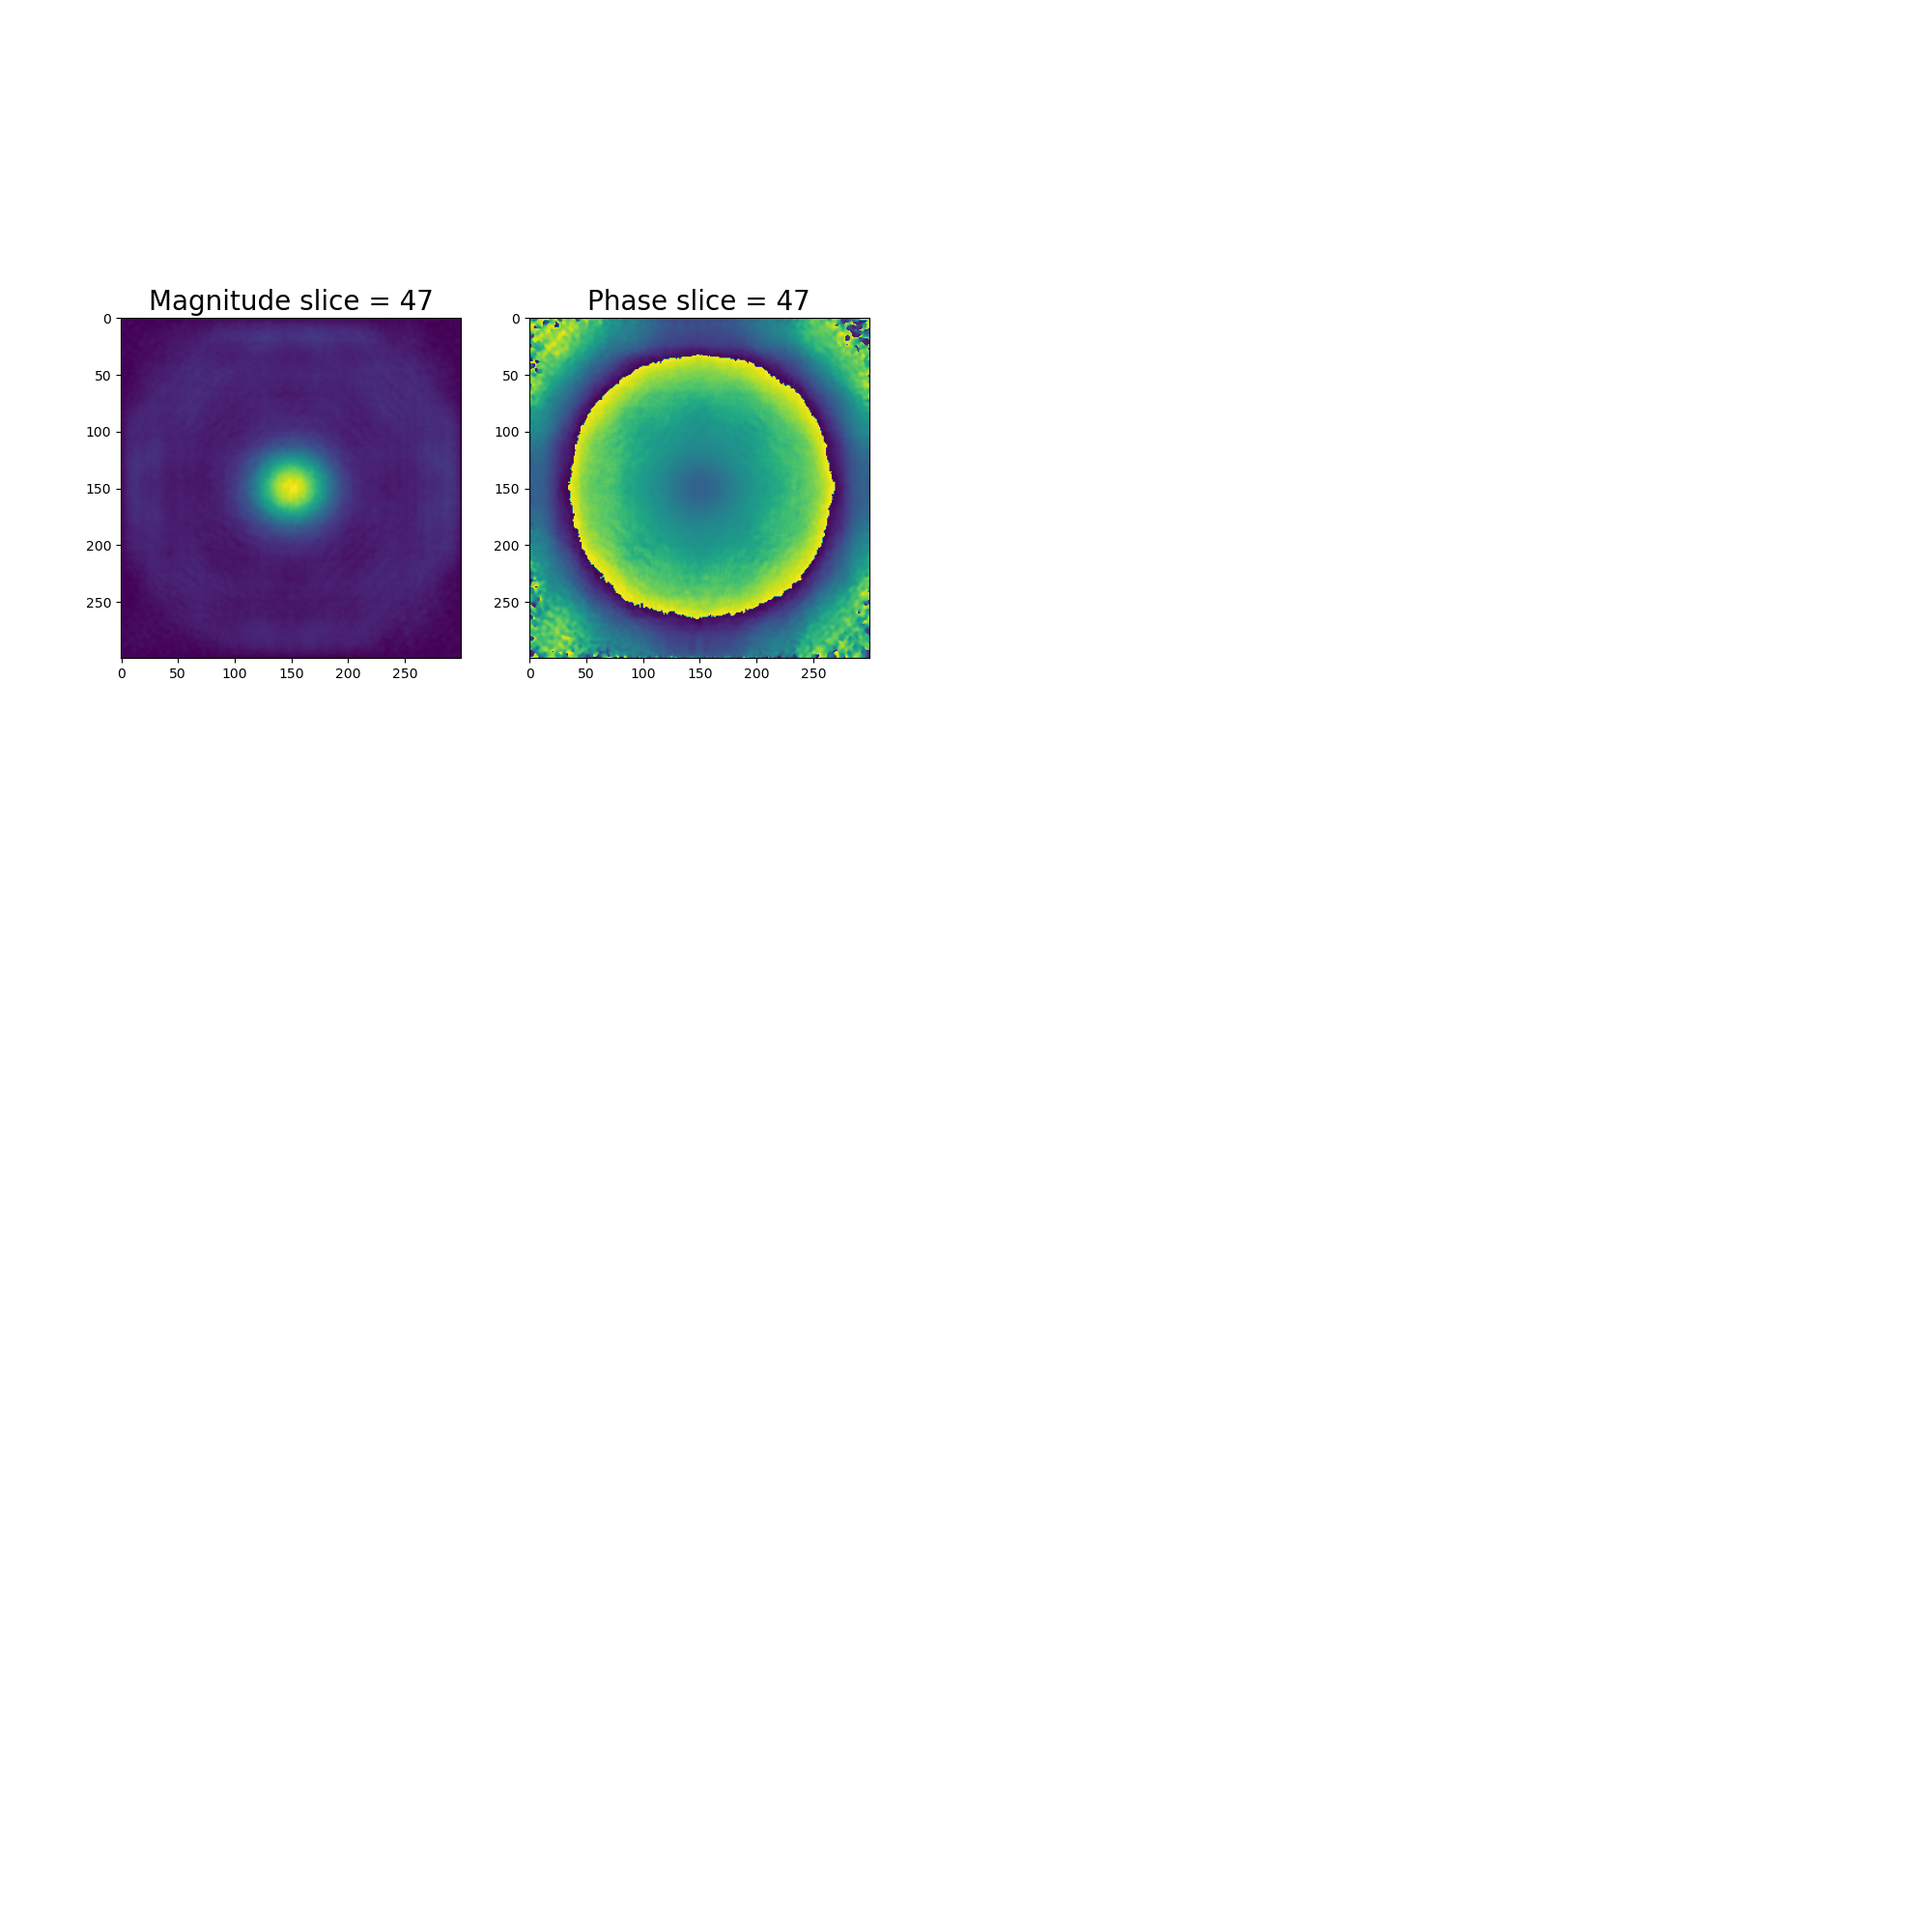

slice000001/field-realslice000001/field-imag


<ipython-input-37-f8907a33e4c3>:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(122)


slice000101/field-realslice000101/field-imag


<ipython-input-37-f8907a33e4c3>:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(122)
<ipython-input-37-f8907a33e4c3>:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(121)


slice000201/field-realslice000201/field-imag
slice000301/field-realslice000301/field-imag
slice000401/field-realslice000401/field-imag
slice000501/field-realslice000501/field-imag
slice000601/field-realslice000601/field-imag
slice000701/field-realslice000701/field-imag
slice000801/field-realslice000801/field-imag
slice000901/field-realslice000901/field-imag
slice001001/field-realslice001001/field-imag
slice001101/field-realslice001101/field-imag
slice001201/field-realslice001201/field-imag
slice001301/field-realslice001301/field-imag
slice001401/field-realslice001401/field-imag
slice001501/field-realslice001501/field-imag
slice001601/field-realslice001601/field-imag
slice001701/field-realslice001701/field-imag
slice001801/field-realslice001801/field-imag
slice001901/field-realslice001901/field-imag
slice002001/field-realslice002001/field-imag
slice002101/field-realslice002101/field-imag
slice002201/field-realslice002201/field-imag
slice002301/field-realslice002301/field-imag
slice00240

In [37]:
# Dataset slice visualization

import time
%matplotlib notebook

fig = plt.figure(figsize=(10,10))

with h5py.File('/Users/kennethshui/python_dir/iCloud_Kenneth/test_pha/many_spikes.643.fld.h5','r') as fldj:

    for it in range(48):
        
        base = 100
        
        sn = ('00000' + str(it*base + 1))
        sn = sn[len(sn)-6 : len(sn)]
        
        rp = 'slice' + sn + '/field-real'
        ip = 'slice' + sn + '/field-imag'
        print(rp + ip)
        
        rfieldj = fldj[rp][()]
        ifieldj = fldj[ip][()]

        rfieldj = rfieldj.reshape([301,301])
        ifieldj = ifieldj.reshape([301,301])

        true_fieldj = rfieldj[0:300, 0:300]+1j*ifieldj[0:300, 0:300]
       
        
        plt.imshow(np.abs(true_fieldj))
        plt.subplot(122)
        plt.imshow(np.angle(true_fieldj))
        
        ax = fig.add_subplot(121)
        im = ax.imshow(np.abs(true_fieldj))
        ax.set_title("Magnitude slice = %d" % it)
        ax.title.set_size(20)
        ax = fig.add_subplot(122)
        im = ax.imshow(np.angle(true_fieldj))
        ax.set_title("Phase slice = %d" % it)
        ax.title.set_size(20)
        fig.canvas.draw()
        #time.sleep(0.05)
        
        
%matplotlib inline

In [192]:
#Here directly import the 2x oversampled F-space magnitude pattern to perform phase retrieval!

image2 = F_Space_Mag
print('F_space_Mag dimension = ', image2.shape)

F_space_Mag dimension =  (600, 600)


Imported F-space dimenstion =  (600, 600)
Original real-space dimension before zero-padding =  (300, 300)
Zero-padded real-space mask dimenstion =  (600, 600)
step 100 of 1000
step 200 of 1000
step 300 of 1000
step 400 of 1000
step 500 of 1000
step 600 of 1000
step 700 of 1000
step 800 of 1000
step 900 of 1000
step 1000 of 1000


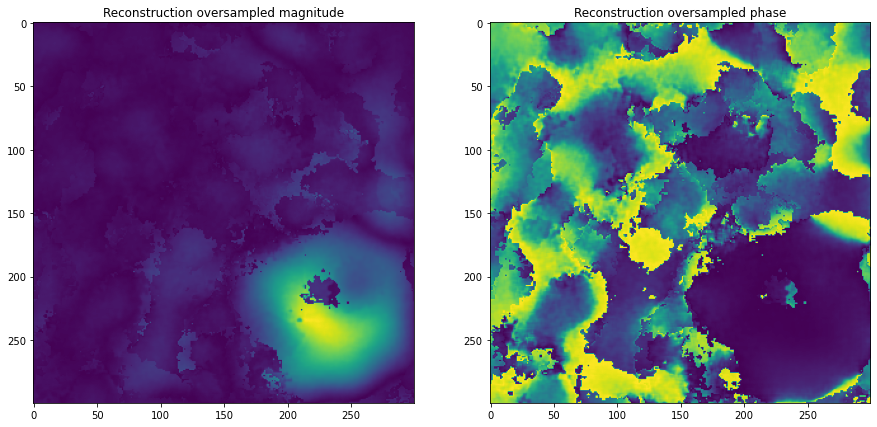

Text(0.5, 0, 'Iterations')

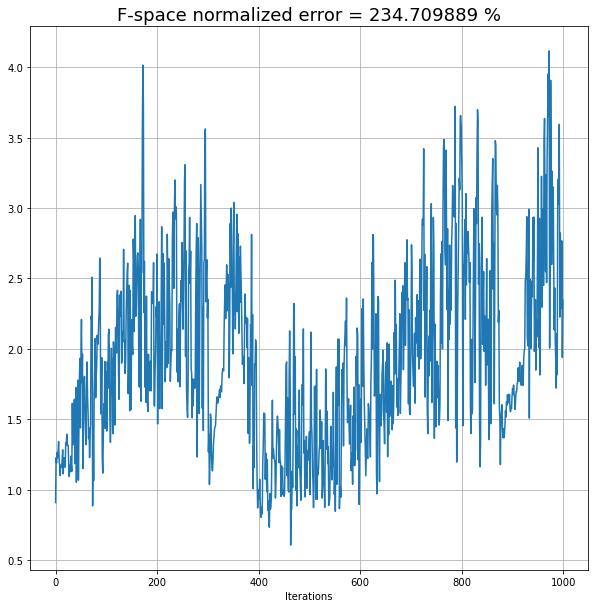

In [193]:
#Perform complex PR

ndim = image2.shape[0]  #Imported F-Space data dimension
#image_in = np.ones([int(ndim/osr), int(ndim/osr)]) #Original real space image without zero padding.
image_in = true_fieldj
image_dim = image_in.shape[0]  #Original real space image dimension

mask = np.pad(np.ones((image_dim,image_dim)), int((osr-1)*image_dim/2), 'constant') #Real space mask

print('Imported F-space dimenstion = ', image2.shape)
print('Original real-space dimension before zero-padding = ', image_in.shape)
print('Zero-padded real-space mask dimenstion = ', mask.shape)

result_oversampled, F_error = fienup_phase_retrieval_complex(image_in, image2, osr=osr, beta=0.95, 
                                                             steps=1000, mode = 'hybrid', 
                                                             mask = mask, verbose=True)

low_bound = int((osr-1)*image_dim/2)
up_bound = int((osr-1)*image_dim/2)+image_dim
plt.figure(figsize=(15,15))
plt.subplot(1,2,1) 
plt.imshow(np.absolute(result_oversampled[low_bound:up_bound, low_bound:up_bound]));
plt.title('Reconstruction oversampled magnitude') 
plt.subplot(1,2,2)
plt.imshow(np.angle(result_oversampled[low_bound:up_bound, low_bound:up_bound]))
plt.title('Reconstruction oversampled phase') 
plt.show()

plt.figure(figsize=(10, 10))
plt.plot(F_error[1:len(F_error)])
plt.grid()
final_F_error = F_error[len(F_error)-1]*100
plt.title("F-space normalized error = %f " %final_F_error +  "%", fontsize=18)
plt.xlabel('Iterations')

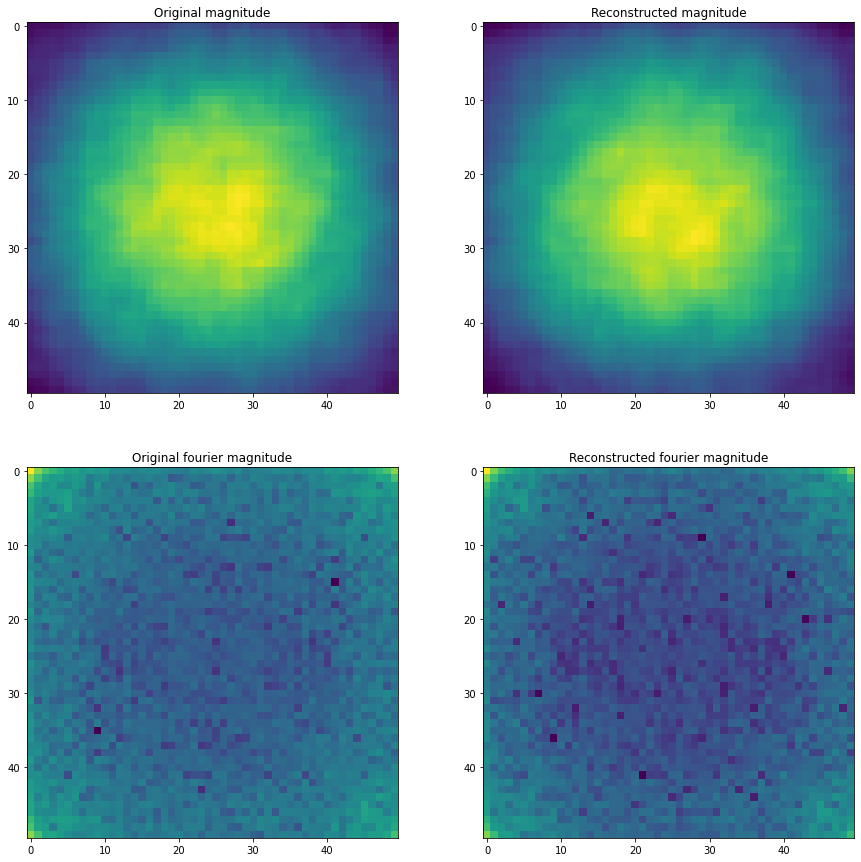

In [178]:
# Magnitude Comparison

orig_mag = np.abs(true_fieldj)
recon_mag = np.abs(result_oversampled[low_bound:up_bound, low_bound:up_bound])

orig_fmag = np.abs(np.fft.fft2(orig_mag))
recon_fmag = np.abs(np.fft.fft2(recon_mag))

plt.figure(figsize=(15,15))
plt.subplot(221) 
plt.imshow(orig_mag)
plt.title('Original magnitude')
#plt.colorbar(shrink=0.80)
plt.subplot(222)
plt.imshow(recon_mag)
plt.title('Reconstructed magnitude')
#plt.colorbar(shrink=0.80)
plt.subplot(223)
plt.imshow(np.log10(orig_fmag))
plt.title('Original fourier magnitude') 
#plt.colorbar(shrink=0.80, label='log scale')
plt.subplot(224)
plt.imshow(np.log10(recon_fmag))
plt.title('Reconstructed fourier magnitude')
#plt.colorbar(shrink=0.80, label='log scale')
plt.show()



In [ ]:
plt.figure(figsize=(15,15))
plt.subplot(221) 
plt.imshow(orig_mag[125:175, 125:175])
plt.title('Original magnitude')
#plt.colorbar(shrink=0.80)
plt.subplot(222)
plt.imshow(recon_mag[125:175, 125:175])
plt.title('Reconstructed magnitude')
#plt.colorbar(shrink=0.80)
plt.subplot(223)
plt.imshow(np.log10(orig_fmag[125:175, 125:175]))
plt.title('Original fourier magnitude') 
#plt.colorbar(shrink=0.80, label='log scale')
plt.subplot(224)
plt.imshow(np.log10(recon_fmag[125:175, 125:175]))
plt.title('Reconstructed fourier magnitude')
#plt.colorbar(shrink=0.80, label='log scale')
plt.show()

Fourier total normalized error: 
0.0568
Magnitude total normalized error: 
0.0187


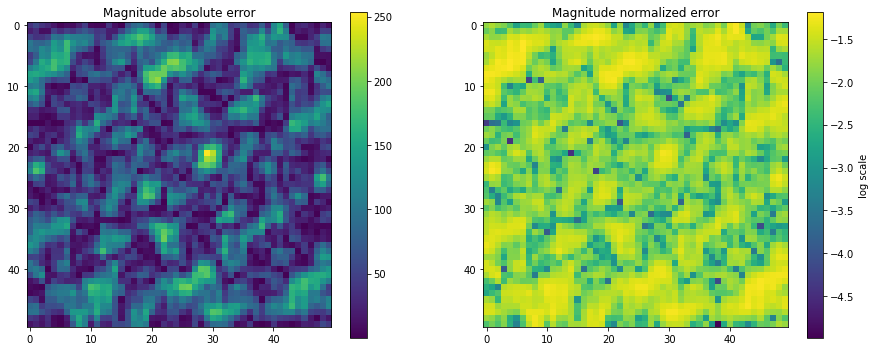

In [179]:
# Magnitude Error

abs_error = np.abs(orig_mag - recon_mag)

print('Fourier total normalized error: ')
normalized_error = np.round(np.sum(np.abs(orig_fmag - recon_fmag)) / np.sum(orig_fmag), 4)
print(normalized_error)

print('Magnitude total normalized error: ')
mag_normalized_error = np.round(np.sum(abs_error) / np.sum(orig_mag), 4)
print(mag_normalized_error)

plt.figure(figsize=(15,15))
plt.subplot(121)
plt.title('Magnitude absolute error') 
plt.imshow(abs_error)
plt.colorbar(shrink=0.40)
plt.subplot(122)
plt.title('Magnitude normalized error')
plt.imshow(np.log10(abs_error / np.abs(true_fieldj)))
plt.colorbar(shrink=0.40, label='log scale')


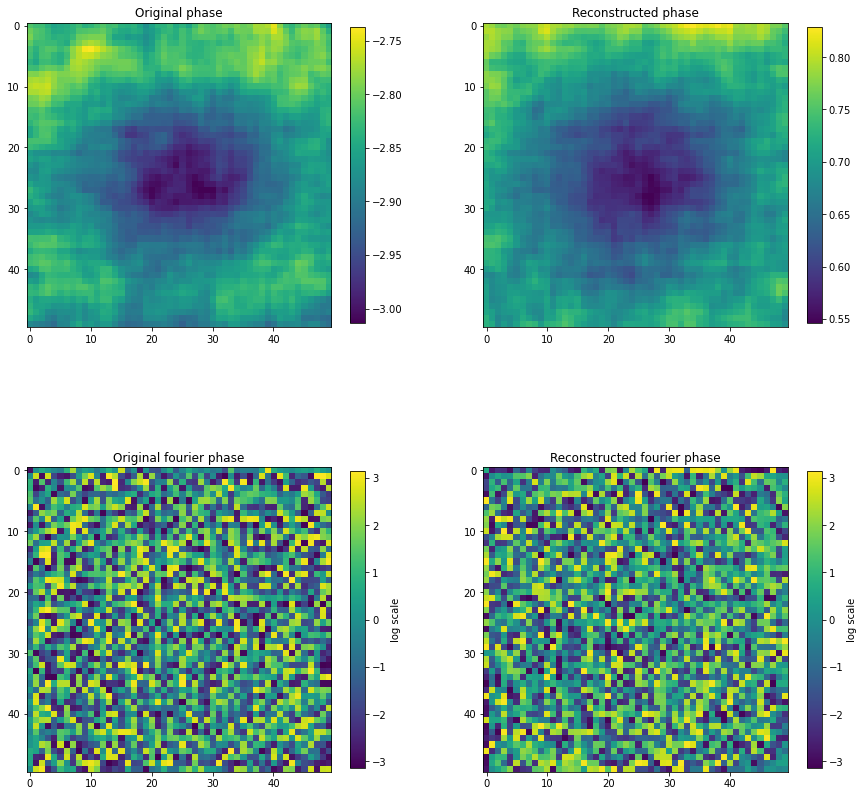

In [180]:
# Phase Comparison

# Phase shifting
orig_phase = np.angle(true_fieldj)
#orig_phase += np.pi
#orig_phase += np.pi/2
#for i in range(orig_phase.shape[0]):
#    for j in range(orig_phase.shape[1]):
#        if orig_phase[i][j] > np.pi:
#            orig_phase[i][j] = orig_phase[i][j] - 2*np.pi

recon_phase = np.angle(result_oversampled[low_bound:up_bound, low_bound:up_bound])
#recon_phase += np.pi
#recon_phase += np.pi/2
#for i in range(recon_phase.shape[0]):
#    for j in range(recon_phase.shape[1]):
#        if recon_phase[i][j] > np.pi:
#            recon_phase[i][j] = recon_phase[i][j] - 2*np.pi

orig_fphase = np.angle(np.fft.fft2(true_fieldj))
recon_fphase = np.angle(np.fft.fft2(result_oversampled[low_bound:up_bound, low_bound:up_bound]))

plt.figure(figsize=(15,15))
plt.subplot(221) 
plt.imshow(orig_phase)
plt.title('Original phase')
plt.colorbar(shrink=0.80)
plt.subplot(222)
plt.imshow(recon_phase)
plt.title('Reconstructed phase') 
plt.colorbar(shrink=0.80)
plt.subplot(223)
plt.imshow(orig_fphase)
plt.title('Original fourier phase') 
plt.colorbar(shrink=0.80, label='log scale')
plt.subplot(224)
plt.imshow(recon_fphase)
plt.title('Reconstructed fourier phase')
plt.colorbar(shrink=0.80, label='log scale')
plt.show()



Fourier total normalized error: 
0.8178
Phase mean squared error: 
0.1695480896580194


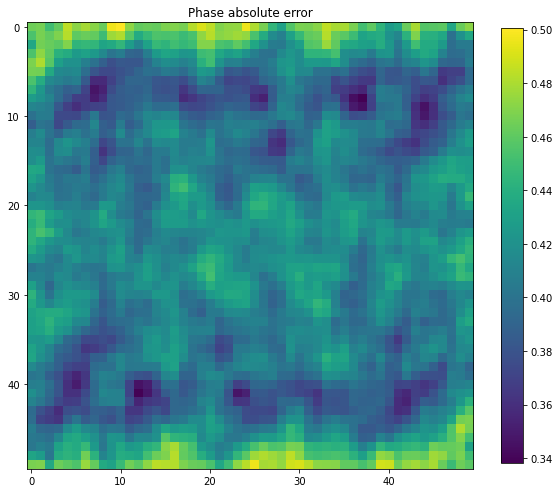

In [182]:
# Phase Error

print('Fourier total normalized error: ')
fphase_ne = np.round(np.sum(np.abs(np.abs(orig_fphase) - np.abs(recon_fphase))) / np.sum(np.abs(orig_fphase)), 4)
print(fphase_ne)


m1 = np.abs(orig_phase - recon_phase)
abs_phase_error = np.zeros(orig_phase.shape)

### Shift
orig_phase += np.pi

for i in range(orig_phase.shape[0]):
    for j in range(orig_phase.shape[1]):
        if orig_phase[i][j] >= 0 and recon_phase[i][j] < 0:
            abs_phase_error[i][j] = np.minimum(np.abs(orig_phase[i][j] - recon_phase[i][j]), np.abs(orig_phase[i][j] - (recon_phase[i][j] + 2*np.pi)))
        elif orig_phase[i][j] < 0 and recon_phase[i][j] >= 0:
            abs_phase_error[i][j] = np.minimum(np.abs(orig_phase[i][j] - recon_phase[i][j]), np.abs((orig_phase[i][j] + 2*np.pi) - recon_phase[i][j]))
        else:
            abs_phase_error[i][j] = np.abs(orig_phase[i][j] - recon_phase[i][j])
        
print('Phase mean squared error: ')
phase_mse = np.sum(abs_phase_error**2) / abs_phase_error.size
print(phase_mse)

plt.figure(figsize=(10,10))
plt.subplot(111)
plt.title('Phase absolute error') 
plt.imshow(abs_phase_error)
plt.colorbar(shrink = 0.80)


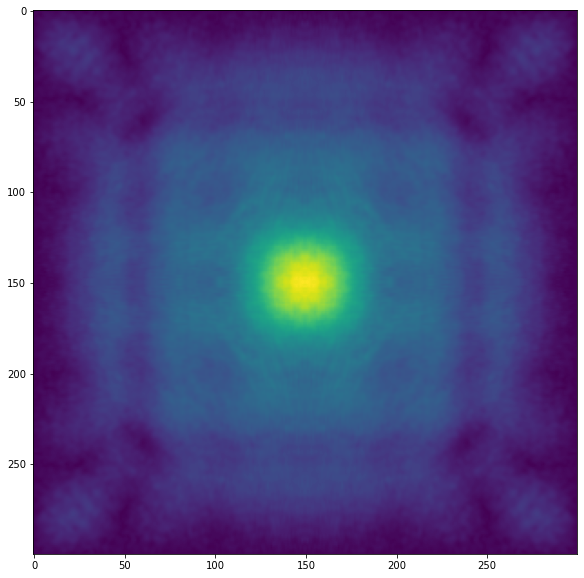

In [79]:
corner_fieldj = np.zeros((300, 300), dtype=complex)
corner_fieldj[:150, :150] = true_fieldj[:150,:150]
corner_fieldj[:150, 150:] = np.flip(true_fieldj[:150,:150], 1)
corner_fieldj[150:, 150:] = np.flip(np.flip(true_fieldj[:150,:150], 1), 0)
corner_fieldj[150:, :150] = np.flip(true_fieldj[:150,:150], 0)

corner_mag = np.abs(pad_fieldj)[:600, :600]

# Reflect
symmetric_mag = np.zeros((1200, 1200))
symmetric_mag[:600, :600] = corner_mag
symmetric_mag[:600, 600:] = np.flip(corner_mag, 1)
symmetric_mag[600:, 600:] = np.flip(np.flip(corner_mag, 1), 0)
symmetric_mag[600:, :600] = np.flip(corner_mag, 0)

# Rotate 
#symmetric_fmag = np.zeros((600, 600))
#symmetric_fmag[:300, :300] = corner_fmag
#symmetric_fmag[300:, :300] = np.rot90(corner_fmag)
#symmetric_fmag[300:, 300:] = np.rot90(np.rot90(corner_fmag))
#symmetric_fmag[:300, 300:] = np.rot90(np.rot90(np.rot90(corner_fmag)))

plt.figure(figsize=(10,10))
plt.imshow(np.abs(corner_fieldj))

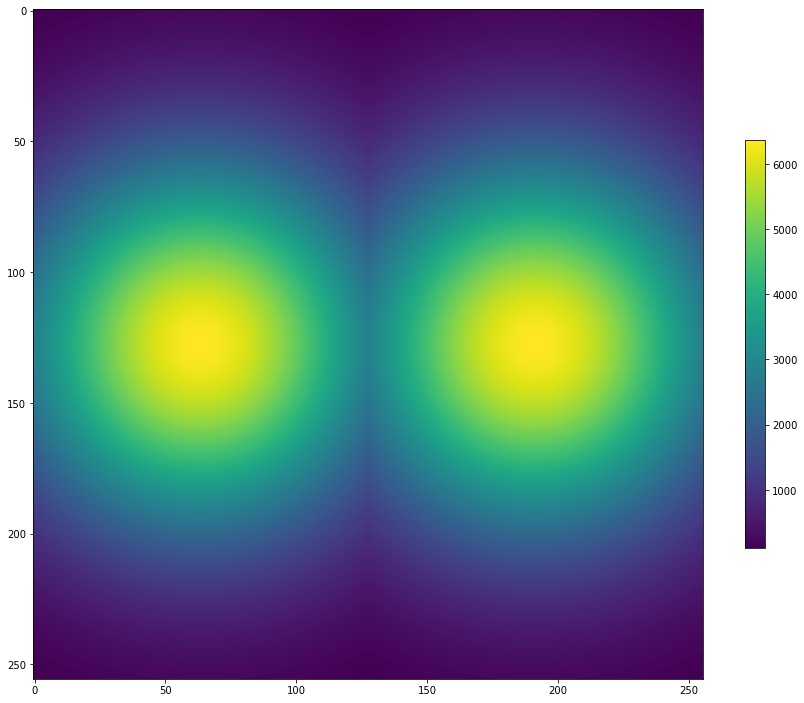

In [23]:
# Two Gaussian Peaks

import numpy as np
import imageio
import matplotlib.pyplot as plt



def gauss(Nx, Ny, sd):
    x = np.ones([Nx,Ny])
    for i in range(Nx):
        for j in range(Ny//2):
            x[i][j] *= 1/(2 * np.pi * sd**2) * np.exp(-((i-(Nx-1)/2)**2 + (j-(Ny/2-1)/2)**2) / (2 * sd**2))
    for i in range(Nx):
        for j in range(Ny//2, Ny):
            x[i][j] *= 1/(2 * np.pi * sd**2) * np.exp(-((i-(Nx-1)/2)**2 + (j-(3*Ny/2-1)/2)**2) / (2 * sd**2))
    return x * 1e8


plt.figure(figsize=(15,15))
plt.imshow(gauss(256, 256, 50))
plt.colorbar(shrink=0.50)
